In [33]:
"""
Let's recap:

We got some data and created a trading rule
"""
from sysdata.sim.db_futures_sim_data import dbFuturesSimData
data = dbFuturesSimData()
from systems.provided.rules.ewmac import ewmac_forecast_with_defaults as ewmac
from systems.provided.rules.carry import carry
from systems.forecasting import Rules
from systems.basesystem import System
from systems.trading_rules import TradingRule
from sysdata.config.configdata import Config
from systems.forecast_scale_cap import ForecastScaleCap
from systems.forecast_combine import ForecastCombine
from systems.accounts.accounts_stage import Account
from systems.rawdata import RawData
from systems.positionsizing import PositionSizing
from systems.portfolio import Portfolios
from sysquant.estimators.vol import robust_vol_calc

def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback
    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html
    
    #Crypto-trend signal
    instrument_code = 'BITCOIN'
    bitcoin_price = data.daily_prices(instrument_code)
    bitcoin_price = price.resample("1B").last()
    bitcoin_fast_ewma = bitcoin_price.ewm(span=20).mean()
    bitcoin_slow_ewma = bitcoin_price.ewm(span=70).mean()
    bitcoin_signal = bitcoin_fast_ewma - bitcoin_slow_ewma
       
    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 3 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    
    # Create the ewmac forecast series
    ewmac_forecast = raw_ewmac / vol
    
    # Override the forecast based on the raw_ewmac value
    ewmac_forecast[raw_ewmac > 0] = 10
    ewmac_forecast[raw_ewmac < 0] = -10
    
    return ewmac_forecast


carry = TradingRule((carry, [], dict()))
ewmac_25 = TradingRule((calc_ewmac_forecast, [], dict(Lfast=10)))
# ewmac_12 = TradingRule(dict(function=calc_ewmac_forecast, other_args=dict(Lfast=12)))
#ewmac_25 = TradingRule(dict(function=calc_ewmac_forecast, other_args=dict(Lfast=25)))
# ewmac_50 = TradingRule(dict(function=calc_ewmac_forecast, other_args=dict(Lfast=50)))
#ewmac_100 = TradingRule(dict(function=calc_ewmac_forecast, other_args=dict(Lfast=100)))

my_rules = Rules(dict(ewmac_25=ewmac_25))

my_config = Config()
my_config

# empty_rules = Rules()
# my_config.trading_rules = dict(ewmac8=ewmac_8, ewmac32=ewmac_32)
# my_system = System([empty_rules], data, my_config)
# my_system.rules.get_raw_forecast("SOFR", "ewmac32").tail(5)


#Try to replicate Faber approximately
# Asset	Allocation	Change
# International Treasuries	5.0%	-
## BUND ? (German 10 year)
# Emerging Market Equities	10.0%	-
## HANG_mini ? (Chinese stocks)
# International Equities	10.0%	-
## DAX (German stocks)
# Gold	10.0%	-
## GOLD_micro
# Int-Term US Treasuries	5.0%	-
## US10
# US Large Cap Value	5.0%	
## SP500-VALUE	
# US Small Cap Value	5.0%	-
## SP600-SMALL
# US Corporate Bonds	5.0%	-
## IG
# US Momentum	10.0%	-
## SP500_micro
# Long-Term US Treasuries	5.0%	
## US30Y_micro
# US Real Estate	20.0%	-
## US-REALESTATE
# Commodities
## BBCOMM
# QQQ
## NASDAQ_micro

# we can estimate these ourselves
#my_config.instruments = ["BUND", "HANG_mini", "DAX", "GOLD_micro", "US10", "R1000", "IG","SP500_micro", "US30", "US-REALESTATE", "BBCOMM", "NASDAQ_micro"]
my_config.instruments = ['BITCOIN']
my_config.use_forecast_scale_estimates = True

fcs = ForecastScaleCap()
combiner = ForecastCombine()
my_account = Account()
combiner = ForecastCombine()
raw_data = RawData()
position_size = PositionSizing()
possizer = PositionSizing()
portfolio = Portfolios()

my_config.percentage_vol_target = 40
my_config.notional_trading_capital = 1000000
my_config.base_currency = "USD"
#my_config.forecast_weight_estimate = dict(method="one_period")
my_config.use_instrument_weight_estimates = True
# my_config.instrument_weights=dict(BITCOIN=0.5, ETHEREUM=0.5),
my_config.use_instrument_div_mult_estimates = True
my_config.use_forecast_weight_estimates = True
my_config.use_forecast_div_mult_estimates = True
#my_config.forecast_floor = 0
#my_config.use_SR_costs = 0

my_system = System(
    [my_account, fcs, my_rules, combiner, possizer, portfolio, raw_data],
    data,
    my_config,
)


# print(my_system.combForecast.get_forecast_weights("SOFR").tail(5))


# # or we can use the values from the book
# my_config.forecast_scalars = dict(ewmac8=5.3, ewmac32=2.65)
# my_config.use_forecast_scale_estimates = False
# fcs = ForecastScaleCap()
# my_system = System([fcs, my_rules], data, my_config)
# print(my_system.forecastScaleCap.get_capped_forecast("SOFR", "ewmac32").tail(5))
my_system.accounts.portfolio().gross.percent.stats()

2024-08-07 14:08:56 DEBUG config {'type': 'config', 'stage': 'config'} Adding config defaults
2024-08-07 14:08:56 DEBUG base_system Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2024-08-07 14:08:56 DEBUG base_system Following instruments are marked as 'ignore_instruments': not included: ['ETHANOL', 'NIFTY', 'USIRS10', 'USIRS2ERIS', 'USIRS5', 'USIRS5ERIS']
2024-08-07 14:08:56 DEBUG base_system Following instruments removed entirely from sim: ['Another_thing', 'ETHANOL', 'NIFTY', 'USIRS10', 'USIRS2ERIS', 'USIRS5', 'USIRS5ERIS', 'bad_thing']
2024-08-07 14:08:56 INFO base_system {'stage': 'accounts'} Calculating pandl for portfolio
2024-08-07 14:08:56 DEBUG base_system {'stage': 'positionSize'} Getting vol target
2024-08-07 14:08:56 DEBUG base_system {'stage': 'accounts', 'instrument_code': 'BITCOIN'} Calculating pandl for instrument for BITCOIN
2024-08-07 14:08:56 DEBUG base_system {'stage': 'portfolio', 'instrument_code': 'BITCOIN'} Calculating notional po

/home/trader/pysystemtrade/sysquant/estimators/forecast_scalar.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaling_factor = scaling_factor.fillna(method="bfill")


2024-08-07 14:08:57 DEBUG base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Using only returns of BITCOIN for gross returns
2024-08-07 14:08:57 DEBUG base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Using unpooled cost SR for BITCOIN
2024-08-07 14:08:57 DEBUG base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Applying cost multiplier of 2.000000
 [================================================================================] 100.0% Optimising weights (0.0/0.0/0.0 secs left/elapsed/total)    
2024-08-07 14:08:57 DEBUG base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Only this set of rules ['ewmac_25'] is cheap enough to trade for BITCOIN
2024-08-07 14:08:58 INFO base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Calculating forecast div multiplier for BITCOIN
2024-08-07 14:08:58 INFO base_system {'stage': 'combForecast', 'instrument_code': 'BITCOIN'} Calculating forecast correlations over BITCOI

[[('min', '-17.41'),
  ('max', '14.14'),
  ('median', '0.022'),
  ('mean', '0.1328'),
  ('std', '2.711'),
  ('skew', '0.1422'),
  ('ann_mean', '34'),
  ('ann_std', '43.38'),
  ('sharpe', '0.7838'),
  ('sortino', '1.098'),
  ('avg_drawdown', '-17.2'),
  ('time_in_drawdown', '0.9358'),
  ('calmar', '0.6726'),
  ('avg_return_to_drawdown', '1.977'),
  ('avg_loss', '-1.812'),
  ('avg_gain', '1.939'),
  ('gaintolossratio', '1.07'),
  ('profitfactor', '1.158'),
  ('hitrate', '0.5198'),
  ('t_stat', '2.036'),
  ('p_value', '0.04188')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

<Axes: xlabel='index'>

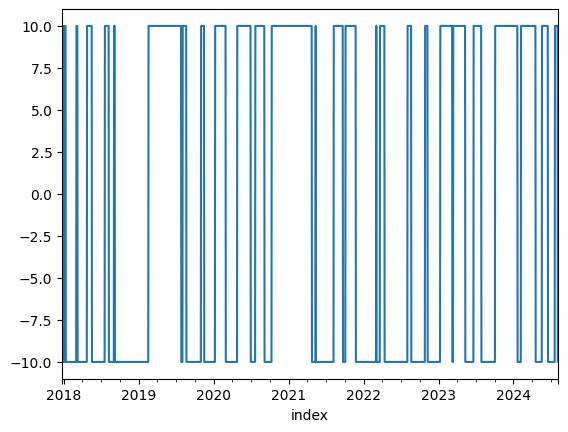

In [34]:
my_system.accounts.get_capped_forecast('BITCOIN', 'ewmac_25').plot()

<Axes: xlabel='index'>

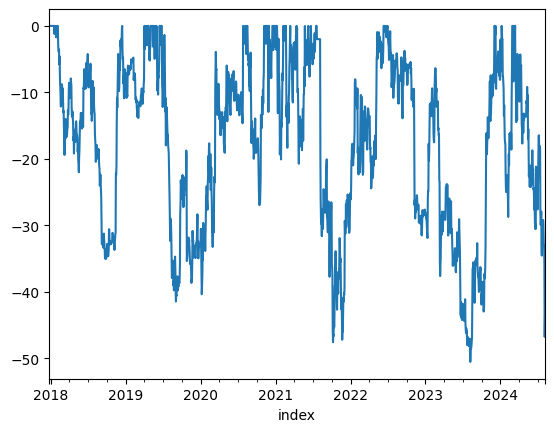

In [35]:
my_system.accounts.portfolio().gross.percent.drawdown().plot()

<Axes: >

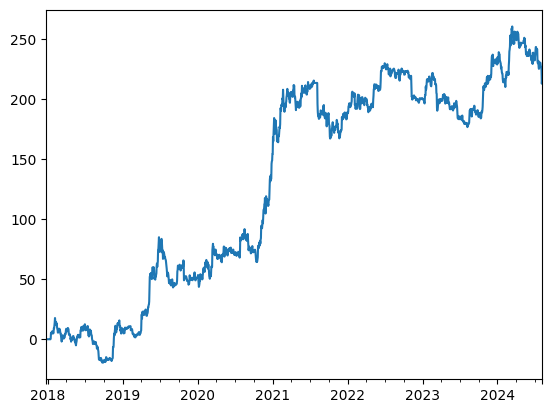

In [36]:
my_system.accounts.portfolio().percent.curve().plot()

In [103]:
daily_returns = my_system.accounts.portfolio().percent / 100
daily_returns.to_csv('crypto_futures.csv')